In [1]:
import gc
import os
import sys
import warnings
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import resnet10t, resnet34d
from torch.cuda import amp
from tqdm import tqdm
from einops import rearrange


In [2]:
sys.path.append('/kaggle/working/notebook/experiment/stacked_unet')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/24-39/"
    dataset_range = train_dataset_path.split("/")[-2]

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============

    z_start = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[0])
    z_end = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[1])
    in_chans = z_end-z_start+1
    
    crop_depth = 6
    random_shift = 2
    layer_shift = [0, 2, 4, 6, 8]
    
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size //2

    train_batch_size = 64  # 32
    valid_batch_size = train_batch_size

    epochs = 30  # 15

    lr = 1e-4
    loss = "bce_dice_loss"


    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


### Load data

In [4]:
def preprocess(image, fragment_i, split_i):
    return image



len(train_images) = 11194
train_images[0].shape = (256, 256, 16)
train_labels[0].shape = (256, 256, 1)
train_masks[0].shape = (256, 256, 1)

len(valid_images) = 3087
valid_images[0].shape = (256, 256, 16)
valid_labels[0].shape = (256, 256, 1)



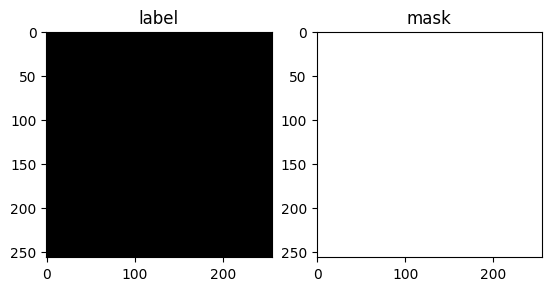

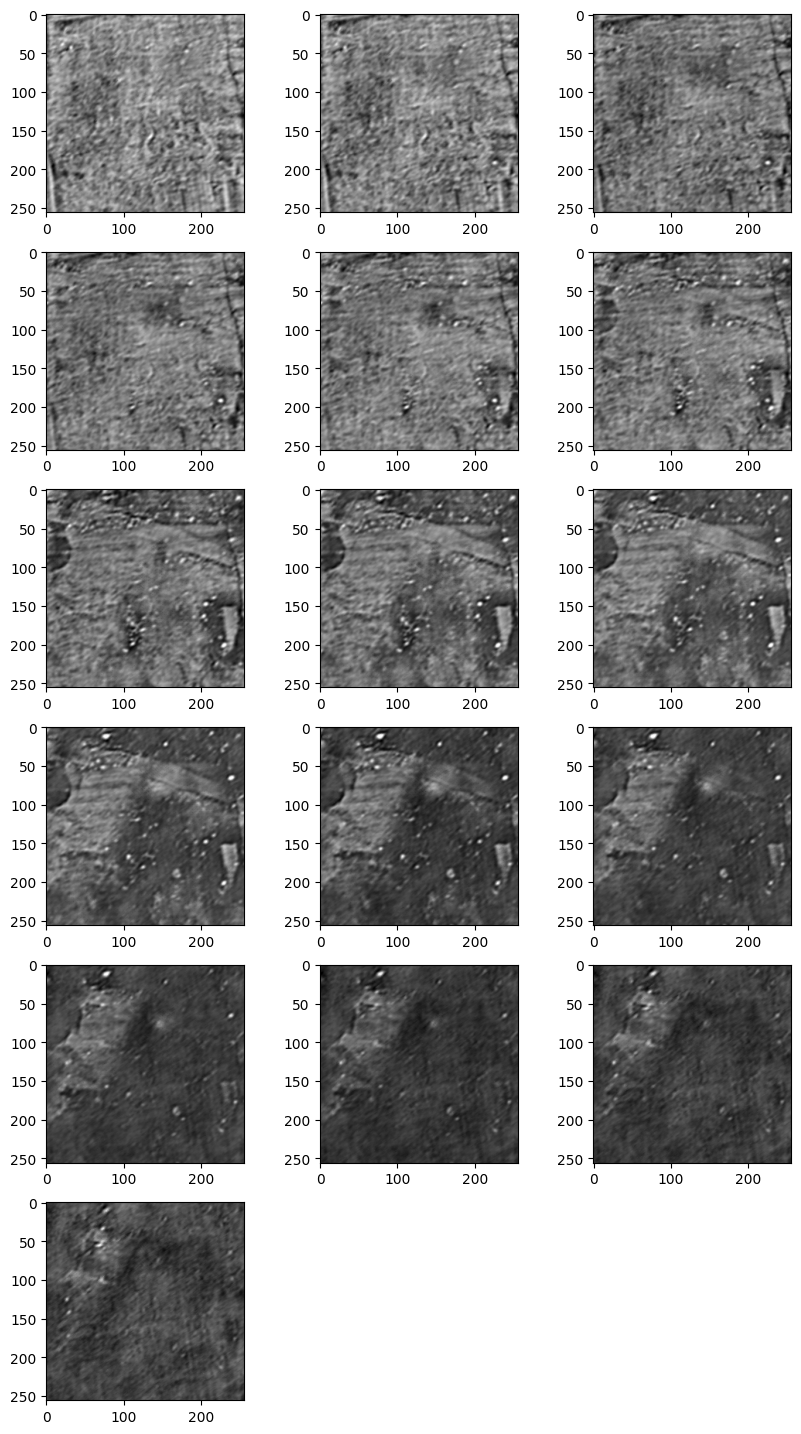

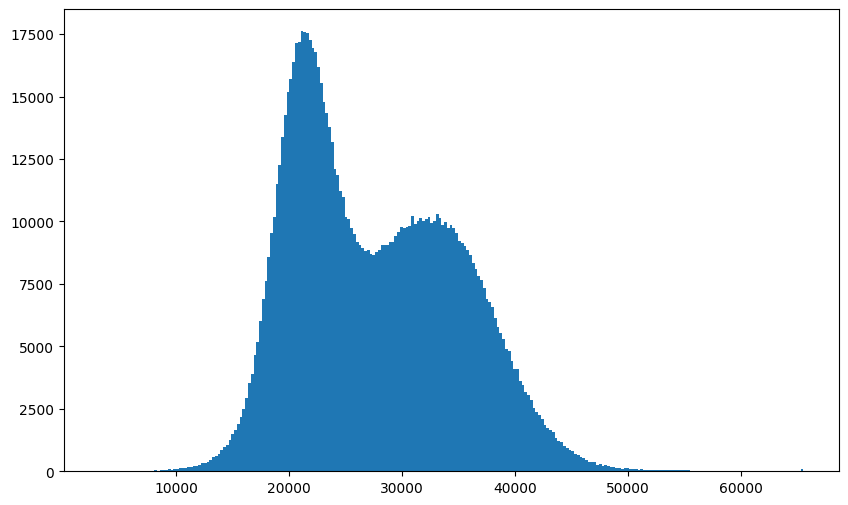

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


### Model

In [6]:
class SmpUnetDecoder(nn.Module):
    def __init__(self,
                 in_channel,
                 skip_channel,
                 out_channel,
                 ):
        super().__init__()
        self.center = nn.Identity()

        i_channel = [in_channel,] + out_channel[:-1]
        s_channel = skip_channel
        o_channel = out_channel
        block = [
            DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
            for i, s, o in zip(i_channel, s_channel, o_channel)
        ]
        self.block = nn.ModuleList(block)

    def forward(self, feature, skip):
        d = self.center(feature)
        decode = []
        for i, block in enumerate(self.block):
            s = skip[i]
            d = block(d, s)
            decode.append(d)

        last = d
        return last, decode


class Net(nn.Module):
    def __init__(self,):
        super().__init__()
        self.output_type = ['inference', 'loss']

        conv_dim = 64
        encoder1_dim = [conv_dim, 64, 128, 256, 512, ]
        decoder1_dim = [256, 128, 64, 64,]

        self.encoder1 = resnet34d(pretrained=True, in_chans=CFG.crop_depth)

        self.decoder1 = SmpUnetDecoder(
            in_channel=encoder1_dim[-1],
            skip_channel=encoder1_dim[:-1][::-1],
            out_channel=decoder1_dim,
        )
        # -- pool attention weight
        self.weight1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ) for dim in encoder1_dim
        ])
        self.logit1 = nn.Conv2d(decoder1_dim[-1], 1, kernel_size=1)

        # --------------------------------
        #
        encoder2_dim = [64, 128, 256, 512]
        decoder2_dim = [128, 64, 32, ]
        self.encoder2 = resnet10t(pretrained=True, in_chans=decoder1_dim[-1])

        self.decoder2 = SmpUnetDecoder(
            in_channel=encoder2_dim[-1],
            skip_channel=encoder2_dim[:-1][::-1],
            out_channel=decoder2_dim,
        )
        self.logit2 = nn.Conv2d(decoder2_dim[-1], 1, kernel_size=1)

    def forward(self, batch):
        v = batch
        B, C, H, W = v.shape
        random_shift = random.randint(0, CFG.random_shift)
        vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
        ]
        K = len(vv)
        x = torch.cat(vv, 0)
        # x = v

        # ----------------------
        encoder = []
        e = self.encoder1
        x = e.conv1(x)
        x = e.bn1(x)
        x = e.act1(x)
        encoder.append(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)
        # print('encoder', [f.shape for f in encoder])

        for i in range(len(encoder)):
            e = encoder[i]
            f = self.weight1[i](e)
            _, c, h, w = e.shape
            f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            w = F.softmax(f, 1)
            e = (w * e).sum(1)
            encoder[i] = e

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder1(feature, skip)
        logit1 = self.logit1(last)

        # ----------------------
        x = last  # .detach()
        # x = F.avg_pool2d(x,kernel_size=2,stride=2)
        encoder = []
        e = self.encoder2
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder2(feature, skip)
        logit2 = self.logit2(last)
        logit1 = F.interpolate(logit1, size=(H, W), mode='bilinear', align_corners=False, antialias=True)
        logit2 = F.interpolate(logit2, size=(H, W), mode='bilinear', align_corners=False, antialias=True)

        return logit1, logit2


### Training

In [7]:
for fold_i, fold in enumerate(glob(f"{CFG.train_dataset_path}/*")):
    fold = os.path.basename(fold).split(".")[0]
    valid_fragment_i = int(fold.split("_")[0])
    valid_split_i = int(fold.split("_")[1])
    print(f"fold: {fold_i}")

    train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess, "inklabels")

    dataloader_train, dataloader_valid = generate_dataloader(train_images, train_labels,  valid_images, valid_labels, valid_xyxys, CFG)

    n_train = len(dataloader_train)
    n_valid = len(dataloader_valid)

    gt_mask = generate_valid_label(valid_fragment_i, valid_split_i, CFG, "inklabels")
    gt_shape = gt_mask.shape


    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))

    model = Net()
    model = nn.DataParallel(model, device_ids=device_ids)
    model = model.cuda()

    scaler = amp.GradScaler()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    fbeta = 0

    for epoch in range(CFG.epochs):
        model.train()
        cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        mloss_train, mloss_val = 0.0, 0.0

        for i, (fragments, masks) in pbar_train:
            fragments, masks = fragments.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():  # type: ignore
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                scaler.scale(loss).backward()# type: ignore
                scaler.step(optimizer)
                scaler.update()
                mloss_train += loss.detach().item()

            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, cur_lr,
                                                                  f"Loss: {mloss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')  # type: ignore
        final_pred_count = torch.zeros(gt_shape)

        for i, (fragments, masks, xys) in pbar_val:
            fragments, masks = fragments.cuda(), masks.cuda()
            with torch.no_grad():
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                mloss_val += loss.detach().item()
                pred_masks = torch.sigmoid(logit2)

            for j, xy in enumerate(xys):
                final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] += pred_masks[j, 0]
                final_pred_count[xy[1]:xy[3], xy[0]:xy[2]] += np.ones((CFG.size, CFG.size))

            pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        final_pred_mask = final_pred_mask.cpu()
        final_pred_mask /= final_pred_count

        fbeta_ = fbeta_score(final_pred_mask, gt_mask, 0.5)
        print(f"FBeta : {fbeta_:.4f}\tSAVED MODEL\n" if fbeta_ > fbeta else f"FBeta : {fbeta_:.4f}\n")
        if fbeta_ > fbeta:
            fbeta = fbeta_
            model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold_i}.pth'
            torch.save({'model': model.module.state_dict(),
                        'preds': final_pred_mask.numpy()},
                       model_path)

    del model
    gc.collect()
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify


fold: 0


Epoch 0/30  Mem : 23.1GB  LR : 1.00E-04  Loss: 0.9650: 100%|██████████| 174/174 
Val Loss: 0.7815: 100%|██████████| 49/49 [00:15<00:00,  3.24it/s]               


FBeta : 0.3527	SAVED MODEL



Epoch 1/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5868: 100%|██████████| 174/174 
Val Loss: 0.8717: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]               


FBeta : 0.2794



Epoch 2/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4772: 100%|██████████| 174/174 
Val Loss: 0.6252: 100%|██████████| 49/49 [00:15<00:00,  3.19it/s]               


FBeta : 0.0154



Epoch 3/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4413: 100%|██████████| 174/174 
Val Loss: 0.4921: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]               


FBeta : 0.4841	SAVED MODEL



Epoch 4/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4201: 100%|██████████| 174/174 
Val Loss: 0.6249: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]               


FBeta : 0.3803



Epoch 5/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4027: 100%|██████████| 174/174 
Val Loss: 1.1930: 100%|██████████| 49/49 [00:15<00:00,  3.22it/s]               


FBeta : 0.3042



Epoch 6/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3879: 100%|██████████| 174/174 
Val Loss: 0.4285: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]               


FBeta : 0.5606	SAVED MODEL



Epoch 7/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3758: 100%|██████████| 174/174 
Val Loss: 0.5606: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]               


FBeta : 0.3922



Epoch 8/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3665: 100%|██████████| 174/174 
Val Loss: 0.5095: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]               


FBeta : 0.4954



Epoch 9/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3556: 100%|██████████| 174/174 
Val Loss: 0.4387: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]               


FBeta : 0.5506



Epoch 10/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3453: 100%|██████████| 174/174
Val Loss: 0.5267: 100%|██████████| 49/49 [00:15<00:00,  3.19it/s]               


FBeta : 0.4600



Epoch 11/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3356: 100%|██████████| 174/174
Val Loss: 0.4380: 100%|██████████| 49/49 [00:15<00:00,  3.19it/s]               


FBeta : 0.5770	SAVED MODEL



Epoch 12/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3278: 100%|██████████| 174/174
Val Loss: 0.5284: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]               


FBeta : 0.4719



Epoch 13/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3213: 100%|██████████| 174/174
Val Loss: 0.4501: 100%|██████████| 49/49 [00:15<00:00,  3.21it/s]               


FBeta : 0.5839	SAVED MODEL



Epoch 14/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3065: 100%|██████████| 174/174
Val Loss: 0.5641: 100%|██████████| 49/49 [00:15<00:00,  3.21it/s]               


FBeta : 0.4235



Epoch 15/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2994: 100%|██████████| 174/174
Val Loss: 0.5383: 100%|██████████| 49/49 [00:15<00:00,  3.21it/s]               


FBeta : 0.4313



Epoch 16/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2878: 100%|██████████| 174/174
Val Loss: 0.4838: 100%|██████████| 49/49 [00:15<00:00,  3.22it/s]               


FBeta : 0.5894	SAVED MODEL



Epoch 17/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2837: 100%|██████████| 174/174
Val Loss: 0.4500: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]               


FBeta : 0.5633



Epoch 18/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2763: 100%|██████████| 174/174
Val Loss: 0.4343: 100%|██████████| 49/49 [00:15<00:00,  3.16it/s]               


FBeta : 0.5983	SAVED MODEL



Epoch 19/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2657: 100%|██████████| 174/174
Val Loss: 0.4760: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]               


FBeta : 0.5355



Epoch 20/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2534: 100%|██████████| 174/174
Val Loss: 0.4614: 100%|██████████| 49/49 [00:15<00:00,  3.24it/s]               


FBeta : 0.6125	SAVED MODEL



Epoch 21/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2473: 100%|██████████| 174/174
Val Loss: 0.5706: 100%|██████████| 49/49 [00:15<00:00,  3.24it/s]               


FBeta : 0.4659



Epoch 22/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2423: 100%|██████████| 174/174
Val Loss: 0.6041: 100%|██████████| 49/49 [00:15<00:00,  3.23it/s]               


FBeta : 0.5353



Epoch 23/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2350: 100%|██████████| 174/174
Val Loss: 0.4731: 100%|██████████| 49/49 [00:15<00:00,  3.21it/s]               


FBeta : 0.5714



Epoch 24/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2262: 100%|██████████| 174/174
Val Loss: 0.4515: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]               


FBeta : 0.6289	SAVED MODEL



Epoch 25/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2179: 100%|██████████| 174/174
Val Loss: 0.5050: 100%|██████████| 49/49 [00:15<00:00,  3.24it/s]               


FBeta : 0.5777



Epoch 26/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2155: 100%|██████████| 174/174
Val Loss: 0.5617: 100%|██████████| 49/49 [00:15<00:00,  3.26it/s]               


FBeta : 0.5707



Epoch 27/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2091: 100%|██████████| 174/174
Val Loss: 0.4837: 100%|██████████| 49/49 [00:15<00:00,  3.23it/s]               


FBeta : 0.5941



Epoch 28/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2044: 100%|██████████| 174/174
Val Loss: 0.5108: 100%|██████████| 49/49 [00:15<00:00,  3.25it/s]               


FBeta : 0.5813



Epoch 29/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2022: 100%|██████████| 174/174
Val Loss: 0.5026: 100%|██████████| 49/49 [00:15<00:00,  3.16it/s]               


FBeta : 0.5898

fold: 1


Epoch 0/30  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.0262: 100%|██████████| 177/177 
Val Loss: 0.6893: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]               


FBeta : 0.3916	SAVED MODEL



Epoch 1/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6590: 100%|██████████| 177/177 
Val Loss: 0.3539: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.4578	SAVED MODEL



Epoch 2/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5208: 100%|██████████| 177/177 
Val Loss: 0.3004: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.4807	SAVED MODEL



Epoch 3/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4762: 100%|██████████| 177/177 
Val Loss: 0.3194: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s]               


FBeta : 0.4220



Epoch 4/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4547: 100%|██████████| 177/177 
Val Loss: 0.2867: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]               


FBeta : 0.5019	SAVED MODEL



Epoch 5/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4386: 100%|██████████| 177/177 
Val Loss: 0.2742: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]               


FBeta : 0.4723



Epoch 6/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4194: 100%|██████████| 177/177 
Val Loss: 0.2722: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.4528



Epoch 7/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4075: 100%|██████████| 177/177 
Val Loss: 0.2662: 100%|██████████| 46/46 [00:14<00:00,  3.11it/s]               


FBeta : 0.5625	SAVED MODEL



Epoch 8/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3949: 100%|██████████| 177/177 
Val Loss: 0.2603: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.5702	SAVED MODEL



Epoch 9/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3866: 100%|██████████| 177/177 
Val Loss: 0.2560: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.5755	SAVED MODEL



Epoch 10/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3716: 100%|██████████| 177/177
Val Loss: 0.2850: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.5506



Epoch 11/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3574: 100%|██████████| 177/177
Val Loss: 0.2610: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]               


FBeta : 0.5742



Epoch 12/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3495: 100%|██████████| 177/177
Val Loss: 0.2827: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]               


FBeta : 0.5860	SAVED MODEL



Epoch 13/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3423: 100%|██████████| 177/177
Val Loss: 0.2759: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.5399



Epoch 14/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3275: 100%|██████████| 177/177
Val Loss: 0.2690: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.5862	SAVED MODEL



Epoch 15/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3179: 100%|██████████| 177/177
Val Loss: 0.2907: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.5760



Epoch 16/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3088: 100%|██████████| 177/177
Val Loss: 0.2744: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.5999	SAVED MODEL



Epoch 17/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3009: 100%|██████████| 177/177
Val Loss: 0.2662: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.5943



Epoch 18/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2887: 100%|██████████| 177/177
Val Loss: 0.2943: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]               


FBeta : 0.5615



Epoch 19/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2800: 100%|██████████| 177/177
Val Loss: 0.2878: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]               


FBeta : 0.5945



Epoch 20/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2693: 100%|██████████| 177/177
Val Loss: 0.2729: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]               


FBeta : 0.6385	SAVED MODEL



Epoch 21/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2580: 100%|██████████| 177/177
Val Loss: 0.2953: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.5938



Epoch 22/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2503: 100%|██████████| 177/177
Val Loss: 0.2784: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6081



Epoch 23/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2440: 100%|██████████| 177/177
Val Loss: 0.2876: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6218



Epoch 24/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2357: 100%|██████████| 177/177
Val Loss: 0.2884: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6000



Epoch 25/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2255: 100%|██████████| 177/177
Val Loss: 0.2900: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]               


FBeta : 0.6132



Epoch 26/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2224: 100%|██████████| 177/177
Val Loss: 0.2887: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6311



Epoch 27/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2167: 100%|██████████| 177/177
Val Loss: 0.2910: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.5960



Epoch 28/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2116: 100%|██████████| 177/177
Val Loss: 0.2953: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6122



Epoch 29/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2092: 100%|██████████| 177/177
Val Loss: 0.3000: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]               


FBeta : 0.6159

fold: 2


Epoch 0/30  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.0069: 100%|██████████| 177/177 
Val Loss: 1.0007: 100%|██████████| 46/46 [00:14<00:00,  3.09it/s]               


FBeta : 0.4014	SAVED MODEL



Epoch 1/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5801: 100%|██████████| 177/177 
Val Loss: 0.7482: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.2218



Epoch 2/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4471: 100%|██████████| 177/177 
Val Loss: 0.6361: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.5399	SAVED MODEL



Epoch 3/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4135: 100%|██████████| 177/177 
Val Loss: 0.6319: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.4449



Epoch 4/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3961: 100%|██████████| 177/177 
Val Loss: 0.7551: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.4304



Epoch 5/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3790: 100%|██████████| 177/177 
Val Loss: 0.6149: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.5474	SAVED MODEL



Epoch 6/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3666: 100%|██████████| 177/177 
Val Loss: 0.5998: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6132	SAVED MODEL



Epoch 7/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3538: 100%|██████████| 177/177 
Val Loss: 0.7746: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.2859



Epoch 8/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3450: 100%|██████████| 177/177 
Val Loss: 0.6954: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.3844



Epoch 9/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3339: 100%|██████████| 177/177 
Val Loss: 0.6989: 100%|██████████| 46/46 [00:14<00:00,  3.10it/s]               


FBeta : 0.5530



Epoch 10/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3309: 100%|██████████| 177/177
Val Loss: 0.6532: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.5483



Epoch 11/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3201: 100%|██████████| 177/177
Val Loss: 0.5517: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6228	SAVED MODEL



Epoch 12/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3110: 100%|██████████| 177/177
Val Loss: 0.6275: 100%|██████████| 46/46 [00:14<00:00,  3.11it/s]               


FBeta : 0.6125



Epoch 13/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2984: 100%|██████████| 177/177
Val Loss: 0.6449: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]               


FBeta : 0.5953



Epoch 14/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2912: 100%|██████████| 177/177
Val Loss: 0.5700: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.6315	SAVED MODEL



Epoch 15/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2861: 100%|██████████| 177/177
Val Loss: 0.6560: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.6346	SAVED MODEL



Epoch 16/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2759: 100%|██████████| 177/177
Val Loss: 0.6059: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.5982



Epoch 17/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2684: 100%|██████████| 177/177
Val Loss: 0.5767: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6753	SAVED MODEL



Epoch 18/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2628: 100%|██████████| 177/177
Val Loss: 0.5449: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6763	SAVED MODEL



Epoch 19/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2531: 100%|██████████| 177/177
Val Loss: 0.5403: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6678



Epoch 20/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2479: 100%|██████████| 177/177
Val Loss: 0.5959: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6744



Epoch 21/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2386: 100%|██████████| 177/177
Val Loss: 0.6062: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.6747



Epoch 22/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2322: 100%|██████████| 177/177
Val Loss: 0.7106: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6474



Epoch 23/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2253: 100%|██████████| 177/177
Val Loss: 0.6711: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6686



Epoch 24/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2213: 100%|██████████| 177/177
Val Loss: 0.6721: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6569



Epoch 25/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2147: 100%|██████████| 177/177
Val Loss: 0.6466: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6644



Epoch 26/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2108: 100%|██████████| 177/177
Val Loss: 0.6468: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6732



Epoch 27/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2066: 100%|██████████| 177/177
Val Loss: 0.6136: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6847	SAVED MODEL



Epoch 28/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2015: 100%|██████████| 177/177
Val Loss: 0.6883: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6781



Epoch 29/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2015: 100%|██████████| 177/177
Val Loss: 0.6323: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.6829

fold: 3


Epoch 0/30  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.0348: 100%|██████████| 177/177 
Val Loss: 0.8674: 100%|██████████| 46/46 [00:14<00:00,  3.10it/s]               


FBeta : 0.3961	SAVED MODEL



Epoch 1/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6118: 100%|██████████| 177/177 
Val Loss: 0.7221: 100%|██████████| 46/46 [00:14<00:00,  3.11it/s]               


FBeta : 0.0000



Epoch 2/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4611: 100%|██████████| 177/177 
Val Loss: 0.6586: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.4681	SAVED MODEL



Epoch 3/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4240: 100%|██████████| 177/177 
Val Loss: 0.5907: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.5402	SAVED MODEL



Epoch 4/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3988: 100%|██████████| 177/177 
Val Loss: 0.6082: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.3967



Epoch 5/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3862: 100%|██████████| 177/177 
Val Loss: 0.5876: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.4347



Epoch 6/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3719: 100%|██████████| 177/177 
Val Loss: 0.7280: 100%|██████████| 46/46 [00:14<00:00,  3.11it/s]               


FBeta : 0.4313



Epoch 7/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3564: 100%|██████████| 177/177 
Val Loss: 0.5328: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6431	SAVED MODEL



Epoch 8/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3491: 100%|██████████| 177/177 
Val Loss: 0.5448: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6166



Epoch 9/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3361: 100%|██████████| 177/177 
Val Loss: 0.5351: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6417



Epoch 10/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3287: 100%|██████████| 177/177
Val Loss: 0.5466: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6302



Epoch 11/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3204: 100%|██████████| 177/177
Val Loss: 0.5342: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6492	SAVED MODEL



Epoch 12/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3125: 100%|██████████| 177/177
Val Loss: 0.5482: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]               


FBeta : 0.6712	SAVED MODEL



Epoch 13/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3033: 100%|██████████| 177/177
Val Loss: 0.6019: 100%|██████████| 46/46 [00:14<00:00,  3.11it/s]               


FBeta : 0.6242



Epoch 14/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2886: 100%|██████████| 177/177
Val Loss: 0.5438: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6918	SAVED MODEL



Epoch 15/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2826: 100%|██████████| 177/177
Val Loss: 0.5584: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.6831



Epoch 16/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2776: 100%|██████████| 177/177
Val Loss: 0.6862: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.5945



Epoch 17/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2669: 100%|██████████| 177/177
Val Loss: 0.5486: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6748



Epoch 18/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2604: 100%|██████████| 177/177
Val Loss: 0.5180: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.6805



Epoch 19/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2587: 100%|██████████| 177/177
Val Loss: 0.5368: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.6989	SAVED MODEL



Epoch 20/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2395: 100%|██████████| 177/177
Val Loss: 0.5670: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6599



Epoch 21/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2325: 100%|██████████| 177/177
Val Loss: 0.5828: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.7073	SAVED MODEL



Epoch 22/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2310: 100%|██████████| 177/177
Val Loss: 0.5557: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.7029



Epoch 23/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2234: 100%|██████████| 177/177
Val Loss: 0.5751: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.6905



Epoch 24/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2153: 100%|██████████| 177/177
Val Loss: 0.5609: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6741



Epoch 25/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2106: 100%|██████████| 177/177
Val Loss: 0.5945: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.6455



Epoch 26/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2044: 100%|██████████| 177/177
Val Loss: 0.6110: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.7029



Epoch 27/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2047: 100%|██████████| 177/177
Val Loss: 0.5834: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.7099	SAVED MODEL



Epoch 28/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1995: 100%|██████████| 177/177
Val Loss: 0.5851: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.6862



Epoch 29/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1954: 100%|██████████| 177/177
Val Loss: 0.5785: 100%|██████████| 46/46 [00:14<00:00,  3.11it/s]               


FBeta : 0.6882

fold: 4


Epoch 0/30  Mem : 23.1GB  LR : 1.00E-04  Loss: 0.9040: 100%|██████████| 185/185 
Val Loss: 0.7199: 100%|██████████| 38/38 [00:12<00:00,  3.08it/s]               


FBeta : 0.2860	SAVED MODEL



Epoch 1/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5830: 100%|██████████| 185/185 
Val Loss: 0.4142: 100%|██████████| 38/38 [00:12<00:00,  3.13it/s]               


FBeta : 0.4710	SAVED MODEL



Epoch 2/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4918: 100%|██████████| 185/185 
Val Loss: 0.3921: 100%|██████████| 38/38 [00:12<00:00,  3.10it/s]               


FBeta : 0.5244	SAVED MODEL



Epoch 3/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4525: 100%|██████████| 185/185 
Val Loss: 0.3894: 100%|██████████| 38/38 [00:12<00:00,  3.08it/s]               


FBeta : 0.5300	SAVED MODEL



Epoch 4/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4350: 100%|██████████| 185/185 
Val Loss: 0.4258: 100%|██████████| 38/38 [00:12<00:00,  3.11it/s]               


FBeta : 0.4528



Epoch 5/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4152: 100%|██████████| 185/185 
Val Loss: 0.3711: 100%|██████████| 38/38 [00:12<00:00,  3.12it/s]               


FBeta : 0.5576	SAVED MODEL



Epoch 6/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4032: 100%|██████████| 185/185 
Val Loss: 0.3513: 100%|██████████| 38/38 [00:12<00:00,  3.10it/s]               


FBeta : 0.5697	SAVED MODEL



Epoch 7/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3881: 100%|██████████| 185/185 
Val Loss: 0.4936: 100%|██████████| 38/38 [00:12<00:00,  3.07it/s]               


FBeta : 0.4461



Epoch 8/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3790: 100%|██████████| 185/185 
Val Loss: 0.3478: 100%|██████████| 38/38 [00:12<00:00,  3.10it/s]               


FBeta : 0.5972	SAVED MODEL



Epoch 9/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3674: 100%|██████████| 185/185 
Val Loss: 0.3515: 100%|██████████| 38/38 [00:12<00:00,  3.10it/s]               


FBeta : 0.5762



Epoch 10/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3574: 100%|██████████| 185/185
Val Loss: 0.3560: 100%|██████████| 38/38 [00:12<00:00,  3.09it/s]               


FBeta : 0.5734



Epoch 11/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3488: 100%|██████████| 185/185
Val Loss: 0.4129: 100%|██████████| 38/38 [00:12<00:00,  3.10it/s]               


FBeta : 0.5180



Epoch 12/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3369: 100%|██████████| 185/185
Val Loss: 0.3425: 100%|██████████| 38/38 [00:12<00:00,  3.09it/s]               


FBeta : 0.6200	SAVED MODEL



Epoch 13/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3277: 100%|██████████| 185/185
Val Loss: 0.3988: 100%|██████████| 38/38 [00:12<00:00,  3.08it/s]               


FBeta : 0.5349



Epoch 14/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3170: 100%|██████████| 185/185
Val Loss: 0.3593: 100%|██████████| 38/38 [00:12<00:00,  3.11it/s]               


FBeta : 0.6083



Epoch 15/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3065: 100%|██████████| 185/185
Val Loss: 0.3376: 100%|██████████| 38/38 [00:12<00:00,  3.09it/s]               


FBeta : 0.6156



Epoch 16/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3016: 100%|██████████| 185/185
Val Loss: 0.3513: 100%|██████████| 38/38 [00:12<00:00,  3.11it/s]               


FBeta : 0.5880



Epoch 17/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2890: 100%|██████████| 185/185
Val Loss: 0.3802: 100%|██████████| 38/38 [00:12<00:00,  3.11it/s]               


FBeta : 0.5567



Epoch 18/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2800: 100%|██████████| 185/185
Val Loss: 0.3391: 100%|██████████| 38/38 [00:12<00:00,  3.10it/s]               


FBeta : 0.6504	SAVED MODEL



Epoch 19/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2677: 100%|██████████| 185/185
Val Loss: 0.3361: 100%|██████████| 38/38 [00:12<00:00,  3.11it/s]               


FBeta : 0.6192



Epoch 20/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2568: 100%|██████████| 185/185
Val Loss: 0.3531: 100%|██████████| 38/38 [00:12<00:00,  3.11it/s]               


FBeta : 0.6602	SAVED MODEL



Epoch 21/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2538: 100%|██████████| 185/185
Val Loss: 0.4736: 100%|██████████| 38/38 [00:12<00:00,  3.12it/s]               


FBeta : 0.4716



Epoch 22/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2446: 100%|██████████| 185/185
Val Loss: 0.3516: 100%|██████████| 38/38 [00:12<00:00,  3.11it/s]               


FBeta : 0.5793



Epoch 23/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2342: 100%|██████████| 185/185
Val Loss: 0.3320: 100%|██████████| 38/38 [00:12<00:00,  3.11it/s]               


FBeta : 0.6201



Epoch 24/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2299: 100%|██████████| 185/185
Val Loss: 0.3815: 100%|██████████| 38/38 [00:13<00:00,  2.81it/s]               


FBeta : 0.5468



Epoch 25/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2201: 100%|██████████| 185/185
Val Loss: 0.3538: 100%|██████████| 38/38 [00:12<00:00,  3.10it/s]               


FBeta : 0.6094



Epoch 26/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2173: 100%|██████████| 185/185
Val Loss: 0.3548: 100%|██████████| 38/38 [00:13<00:00,  2.79it/s]               


FBeta : 0.5895



Epoch 27/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2134: 100%|██████████| 185/185
Val Loss: 0.3452: 100%|██████████| 38/38 [00:12<00:00,  3.10it/s]               


FBeta : 0.6172



Epoch 28/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2081: 100%|██████████| 185/185
Val Loss: 0.3416: 100%|██████████| 38/38 [00:12<00:00,  3.10it/s]               


FBeta : 0.6289



Epoch 29/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2058: 100%|██████████| 185/185
Val Loss: 0.3496: 100%|██████████| 38/38 [00:12<00:00,  3.08it/s]               


FBeta : 0.6089

{"status":200,"message":"ok"}

In [8]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.6289
fbeta: 0.6385
fbeta: 0.6847
fbeta: 0.7099
fbeta: 0.6602


In [9]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.6642


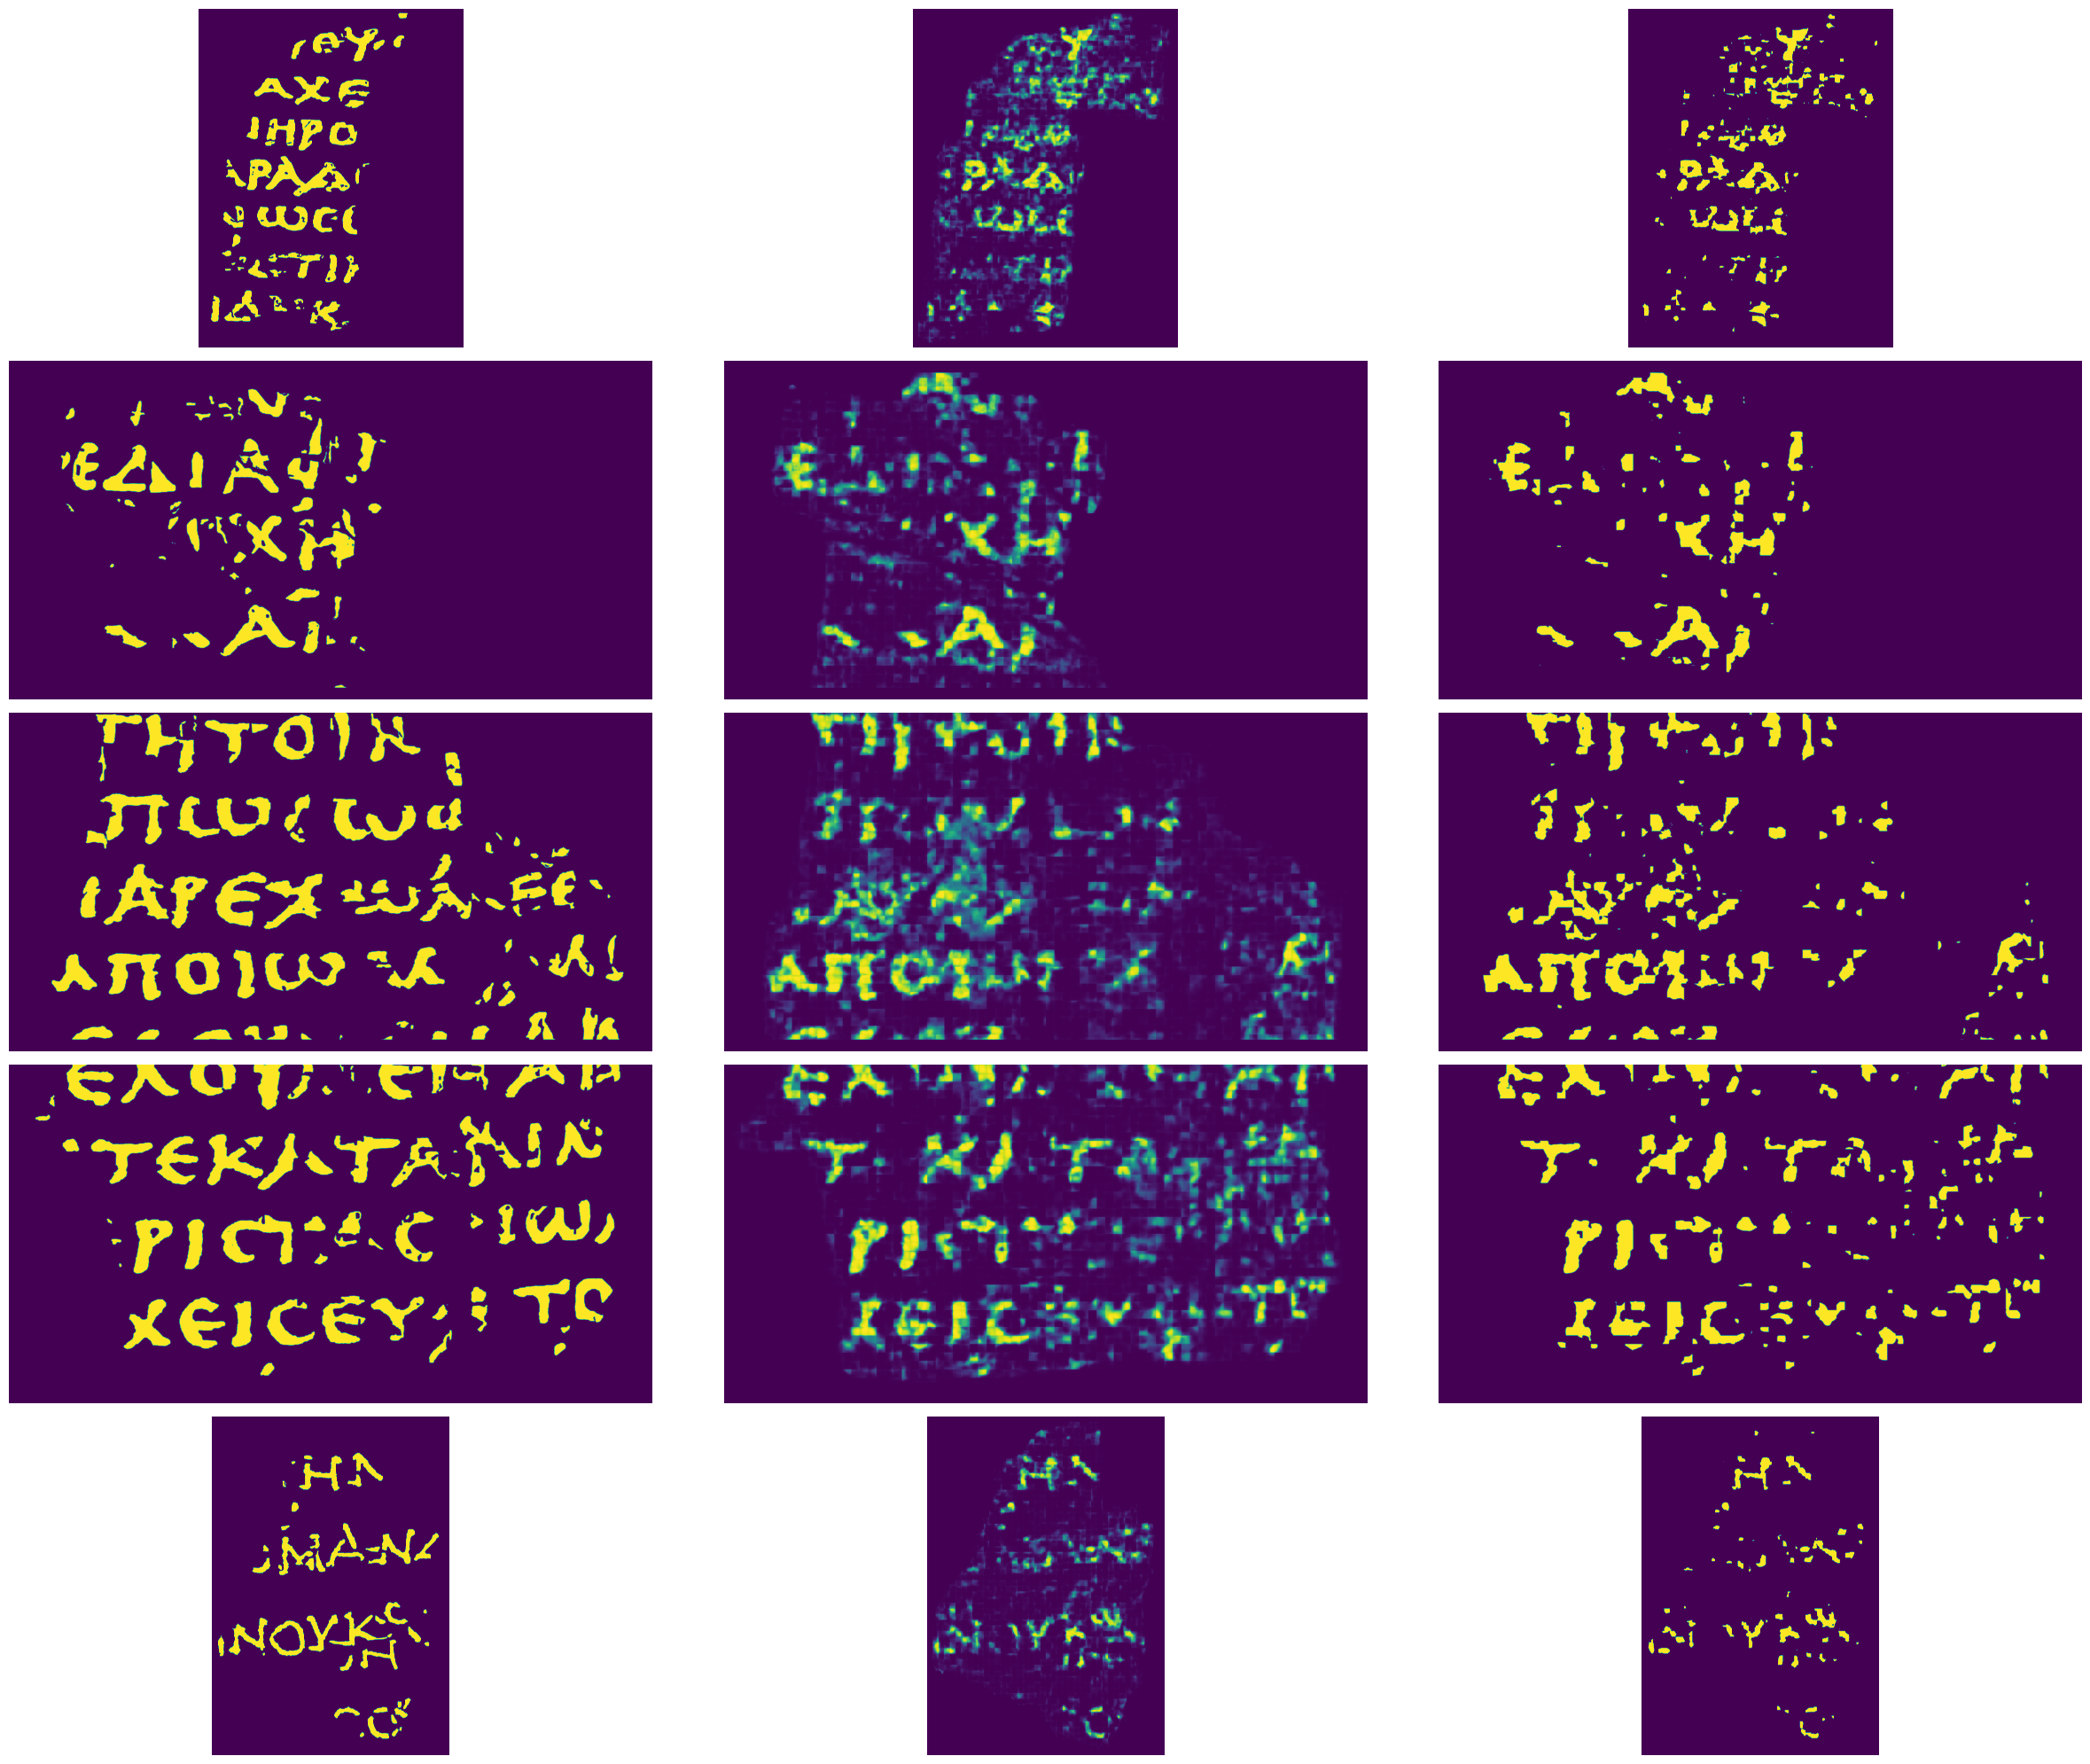

In [10]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)